# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

# Data Reading & Overview

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(f"Duplicates in Train Dataset are:{train.duplicated().sum()}")
print(f"Duplicates in Test Dataset are:{test.duplicated().sum()}")

Duplicates in Train Dataset are:0
Duplicates in Test Dataset are:0


In [4]:
print("Data Types of features of Training Data is:")
print(train.dtypes)
print("\n"+"-"*80)
print("\nData types of features of Testing Data is:")
print(test.dtypes)

Data Types of features of Training Data is:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

--------------------------------------------------------------------------------

Data types of features of Testing Data is:
PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [5]:
train.shape
test.shape

(418, 11)

In [3]:
df1 = (train.isnull().sum()[train.isnull().sum()>0]).to_frame().rename(columns={0:"Number of Missing values"})
df1["% of Missing Values"] = round((100*train.isnull().sum()[train.isnull().sum()>0]/len(train)),2)
df1

df2 = (test.isnull().sum()[test.isnull().sum()>0]).to_frame().rename(columns={0:"Number of Missing values"})
df2["% of Missing Values"] = round((100*test.isnull().sum()[test.isnull().sum()>0]/len(test)),2).values
df2

,Number of Missing values,% of Missing Values
Age,86,20.57
Fare,1,0.24
Cabin,327,78.23


In [7]:
print("Cardinality of categorical features in training datasets is:")
print(train.select_dtypes(include="object").nunique())
print("\n","-"*70)
print("\nCardinality of categorical features in testing datsets is:")
print(test.select_dtypes(include="object").nunique())

Cardinality of categorical features in training datasets is:
Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

 ----------------------------------------------------------------------

Cardinality of categorical features in testing datsets is:
Name        418
Sex           2
Ticket      363
Cabin        76
Embarked      3
dtype: int64


# Data Visualization

# Survival Pie Chart Overview
People who have survived are almost half as those who have not. So we might need some over-sampling in case we want to fine tune the model.

In [ ]:
counts = train['Survived'].value_counts()
labels = counts.index[::-1]
sizes = counts.values[::-1]
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Target Distribution')
plt.axis('equal')
plt.show()

# Age-Survival Histogram Overview
We might want to make separate bins for age, maybe like age 0-10, 10-20 and so and so on, so to better visualize survival, as the middle region has no one surviving.

In [ ]:
plt.figure(figsize=(16,6))
sns.histplot(
    data=train, 
    x='Age', 
    hue='Survived', 
    kde=True, 
    bins=30, 
    palette='Set2', 
    hue_order=train['Survived'].unique()[::-1])

plt.title('Age Distribution by Target')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Embarked-Survival Count Plot Overview
We can see that people embarked from Southampton are more likely to die while the other 2 ports have almost equally likely death ratios.

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=train, x='Embarked', hue='Survived', palette={0: '#fc8d62', 1: '#66c2a5'})
plt.title('Embarked vs Survived')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.show()

# SibSp-Survival Count Plot
People have a sibling or spouse seem to have a less rate of drowning that single ones.

In [ ]:
sns.countplot(data=train, x='SibSp', hue='Survived', palette={0: '#fc8d62', 1: '#66c2a5'})
plt.title('Survival Distribution')
plt.xlabel('SibSp')
plt.ylabel('Count')
plt.show()

# Parch-Survival Count Plot
People having parents or children have high chance of survival as compared to those who don't.

In [ ]:
sns.countplot(data=train, x='Parch', hue='Survived', palette={0: '#fc8d62', 1: '#66c2a5'})
plt.title('Survival Distribution')
plt.xlabel('Parch')
plt.ylabel('Count')
plt.show()

# Pclass-Survival Count Plot
We can see that most of the people in Pclass 3 died while same number of people died and survived in Pclass 2 while in Pclass 1 more people survived.
**Seems interesting!**

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=train, x='Pclass', hue='Survived', palette={0: '#fc8d62', 1: '#66c2a5'})
plt.title('Pclass vs Survived')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()

# Gender-Survival Count Plot
We can see that more men survived than women.

In [ ]:
sns.countplot(data=train, x='Sex', hue='Survived', palette={0: '#fc8d62', 1: '#66c2a5'})
plt.title('Gender vs Survived')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Fare-Survival Count Plot

In [ ]:
plt.figure(figsize=(16,6))
sns.histplot(
    data=train, 
    x='Fare', 
    hue='Survived', 
    kde=True, 
    bins=30, 
    palette={0: '#fc8d62', 1: '#66c2a5'}, 
)

plt.title('Fare Distribution by Survival')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show()

# Correlation Matrix


In [ ]:
corr = train.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Feature Engineering

# Solo Feature

In [4]:
# Passengers who don't have Parch or Sibsp
def solo(df):
    df['Solo'] = ((df['SibSp'] == 0) & (df['Parch'] == 0)).astype(int)
    return df

In [5]:
train = solo(train)
test = solo(test)

# Solo-Survival Count Plot
This seems as an important feature as most of the solo people died.

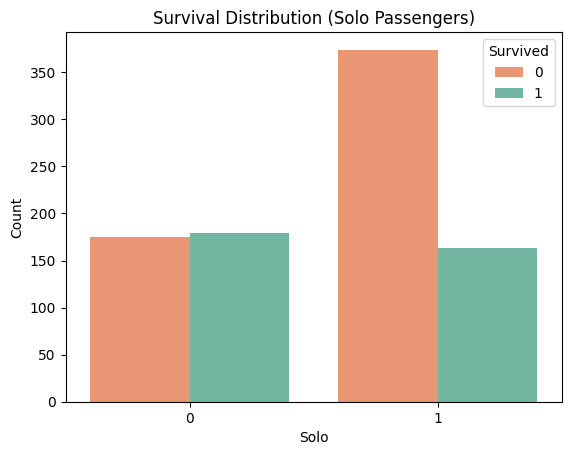

In [10]:
sns.countplot(data=train, x='Solo', hue='Survived', palette={0: '#fc8d62', 1: '#66c2a5'})
plt.title('Survival Distribution (Solo Passengers)')
plt.xlabel('Solo')
plt.ylabel('Count')
plt.show()

# Age Groups

In [6]:
def age_group(df):
    age_group  = []
    for i in df["Age"]:
        if i<=12:
            age_group.append("Age_0-12")
        elif (i>12 and i<=18):
            age_group.append("Age_0-18")
        elif (i>18 and i<=25):
            age_group.append("Age_19-25")
        elif (i>25 and i<=32):
            age_group.append("Age_26-32")
        elif (i>32 and i<=50):
            age_group.append("Age_33_50")
        elif (i>50):
            age_group.append("age_50+")
        else:
            age_group.append(np.nan)
        
    df["Age Group"] = age_group

In [7]:
age_group(train)
age_group(test)

# Age Group Count Plot

In [ ]:
order = sorted(train["Age Group"].value_counts().keys().to_list())

plt.figure(figsize=(14,6))
sns.countplot(x="Age Group",hue="Survived", data=train, palette={0: '#fc8d62', 1: '#66c2a5'},order=order)
plt.title("Age Group Distribution")

# Fare Categories

In [8]:
def add_fare_category(df):
    df['Fare_Category'] = pd.qcut(
        df['Fare'], 
        q=3, 
        labels=['Low', 'Medium', 'High']
    )
    return df

In [9]:
train = add_fare_category(train)
test = add_fare_category(test)

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Solo,Age Group,Fare_Category
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Age_19-25,Low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Age_33_50,High
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Age_26-32,Low
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,Age_33_50,High
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Age_33_50,Low


# Fare Category Count Plot

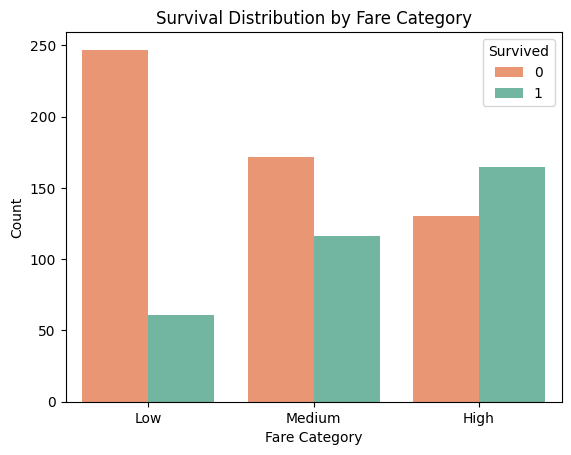

In [16]:
sns.countplot(data=train, x='Fare_Category', hue='Survived', palette={0: '#fc8d62', 1: '#66c2a5'})
plt.title('Survival Distribution by Fare Category')
plt.xlabel('Fare Category')
plt.ylabel('Count')
plt.show()

# Data Preprocessing

In [10]:
z = train.isnull().sum()[train.isnull().sum()>0].to_frame().rename(columns={0:"No. of Missing values"})
z["% of Missing values"] = round(train.isnull().sum()[train.isnull().sum()>0]*100/len(train),2)
z

,No. of Missing values,% of Missing values
Age,177,19.87
Cabin,687,77.10
Embarked,2,0.22
Age Group,177,19.87


In [11]:
# Dividing data into categorical and numerical columns
cat_cols = train.select_dtypes(include=["object","bool", "category"]).columns.tolist()
num_cols = train.select_dtypes(include=["int","float"]).columns.tolist()
num_cols.remove("Survived")

In [12]:
print("Categorical Columns:",cat_cols)
print("\n","-"*80)
print("\nNumerical Columns:",num_cols)

Categorical Columns: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age Group', 'Fare_Category']

 --------------------------------------------------------------------------------

Numerical Columns: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Solo']


# Non Imputed Model

Survived         0
Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
Age Group        0
Fare_Category    0
Sex_female       0
Sex_male         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Solo_0           0
Solo_1           0
dtype: int64
-------------


Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
Age Group        0
Fare_Category    0
Sex_female       0
Sex_male         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Solo_0           0
Solo_1           0
dtype: int64

In [20]:
# Using mode for categorical data and median for numerical data
imputer1 = SimpleImputer(strategy="most_frequent")  
imputer2 = SimpleImputer(strategy="median")

In [21]:
def fill_missingno(df):
    df[cat_cols] = imputer1.fit_transform(df[cat_cols])
    df[num_cols] = imputer2.fit_transform(df[num_cols])

In [22]:
fill_missingno(train)
fill_missingno(test)

In [23]:
print("Missing numbers left in train_df are:",train.isnull().sum().sum())
print("Missing numbers left in test_df are:",test.isnull().sum().sum())

Missing numbers left in train_df are: 0
Missing numbers left in test_df are: 0


In [24]:
print("Duplicate values in training data are: ",train.duplicated().sum())
print("Duplicate values in testing data are: ",test.duplicated().sum())

Duplicate values in training data are:  0
Duplicate values in testing data are:  0


In [34]:
# Useless columns
cols = ['PassengerId', 'Name', 'Cabin', 'Ticket']

train.drop(columns =cols, inplace=True)
test.drop(columns=cols, inplace=True)

KeyError: "['PassengerId', 'Name', 'Cabin', 'Ticket'] not found in axis"

In [17]:
nominal_cat_cols = ['Sex', 'Embarked', 'Solo']
ordinal_cat_cols = ['Pclass', 'Age Group', 'Fare_Category']

In [18]:
enc = LabelEncoder()

In [19]:
# Label encoding for ordinal data, so to preserve ordinal meaning
train[ordinal_cat_cols] = train[ordinal_cat_cols].apply(enc.fit_transform)
test[ordinal_cat_cols] = test[ordinal_cat_cols].apply(enc.fit_transform)

In [20]:
# One hot encoding for nominal data, to remove order
train = pd.get_dummies(train,columns=nominal_cat_cols)
test = pd.get_dummies(test,columns=nominal_cat_cols)

In [22]:
cols = ['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q']

train[cols] = train[cols].astype(int)
test[cols] = test[cols].astype(int)

In [23]:
X = train.drop(columns=['Survived'])
X.columns = X.columns.str.replace(' ', '_')
y = train['Survived']

In [24]:
# Feature Scaling
scaler = StandardScaler()

In [25]:
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.fit_transform(test)

# Unscaled Data Split

In [26]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(712, 14) (712,)
(179, 14) (179,)


# Scaled Data Split

In [27]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled,y,test_size=0.2,random_state=0)

print(x_train_scaled.shape, y_train_scaled.shape)
print(x_test_scaled.shape, y_test_scaled.shape)

(712, 14) (712,)
(179, 14) (179,)


# Model For Scaled Data

In [28]:
training_score = []
testing_score = []

def model_prediction(model):
    model.fit(x_train_scaled,y_train_scaled)
    x_train_pred_scaled = model.predict(x_train_scaled)
    x_test_pred_scaled = model.predict(x_test_scaled)
    a = accuracy_score(y_train_scaled,x_train_pred_scaled)*100
    b = accuracy_score(y_test_scaled,x_test_pred_scaled)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print("\n------------------------------------------------------------------------")
    print(f"Precision Score of {model} model is:",precision_score(y_test_scaled,x_test_pred_scaled))
    print(f"Recall Score of {model} model is:",recall_score(y_test_scaled,x_test_pred_scaled))
    print(f"F1 Score of {model} model is:",f1_score(y_test_scaled,x_test_pred_scaled))
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test_scaled,x_test_pred_scaled)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt="g",cmap="summer")
    plt.show()


# Logistic Regression

In [29]:
model_prediction(LogisticRegression())

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# KNN

Accuracy_Score of KNeighborsClassifier() model on Training Data is: 85.67415730337079
Accuracy_Score of KNeighborsClassifier() model on Testing Data is: 83.24022346368714

------------------------------------------------------------------------
Precision Score of KNeighborsClassifier() model is: 0.8
Recall Score of KNeighborsClassifier() model is: 0.7536231884057971
F1 Score of KNeighborsClassifier() model is: 0.7761194029850746

------------------------------------------------------------------------
Confusion Matrix of KNeighborsClassifier() model is:


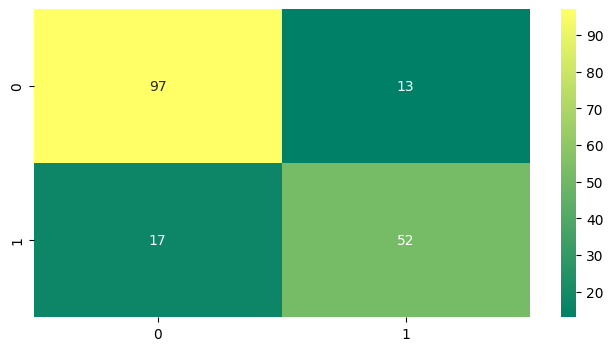

In [39]:
model_prediction(KNeighborsClassifier())

# SVC

Accuracy_Score of SVC() model on Training Data is: 83.98876404494382
Accuracy_Score of SVC() model on Testing Data is: 81.56424581005587

------------------------------------------------------------------------
Precision Score of SVC() model is: 0.7903225806451613
Recall Score of SVC() model is: 0.7101449275362319
F1 Score of SVC() model is: 0.7480916030534351

------------------------------------------------------------------------
Confusion Matrix of SVC() model is:


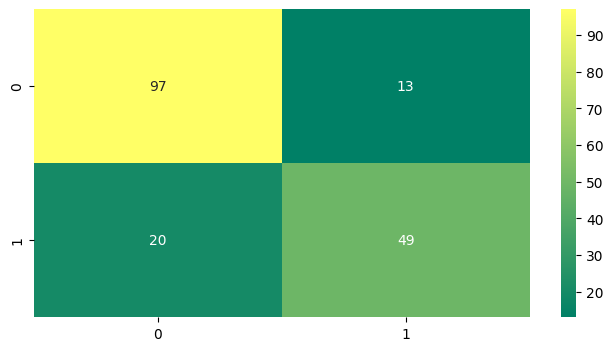

In [40]:
model_prediction(SVC())

# Naive Bayes

Accuracy_Score of GaussianNB() model on Training Data is: 78.65168539325843
Accuracy_Score of GaussianNB() model on Testing Data is: 79.3296089385475

------------------------------------------------------------------------
Precision Score of GaussianNB() model is: 0.7162162162162162
Recall Score of GaussianNB() model is: 0.7681159420289855
F1 Score of GaussianNB() model is: 0.7412587412587412

------------------------------------------------------------------------
Confusion Matrix of GaussianNB() model is:


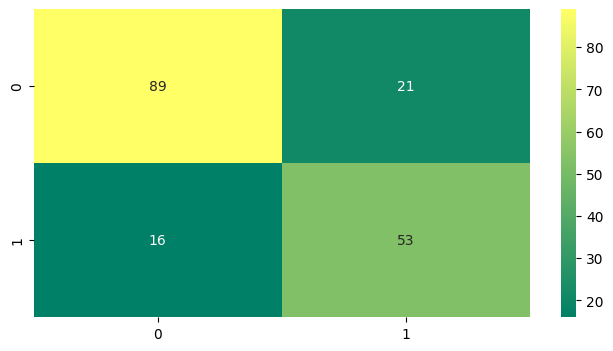

In [41]:
model_prediction(GaussianNB())

# Model For Un Scaled Data

In [42]:
def model_prediction(model):
    model.fit(x_train,y_train)
    x_train_pred = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    a = accuracy_score(y_train,x_train_pred)*100
    b = accuracy_score(y_test,x_test_pred)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print("\n------------------------------------------------------------------------")
    print(f"Precision Score of {model} model is:",precision_score(y_test,x_test_pred))
    print(f"Recall Score of {model} model is:",recall_score(y_test,x_test_pred))
    print(f"F1 Score of {model} model is:",f1_score(y_test,x_test_pred))
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test,x_test_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt="g",cmap="summer")
    plt.show()

# Decision Tree Classifier

Accuracy_Score of DecisionTreeClassifier() model on Training Data is: 98.17415730337079
Accuracy_Score of DecisionTreeClassifier() model on Testing Data is: 80.44692737430168

------------------------------------------------------------------------
Precision Score of DecisionTreeClassifier() model is: 0.765625
Recall Score of DecisionTreeClassifier() model is: 0.7101449275362319
F1 Score of DecisionTreeClassifier() model is: 0.736842105263158

------------------------------------------------------------------------
Confusion Matrix of DecisionTreeClassifier() model is:


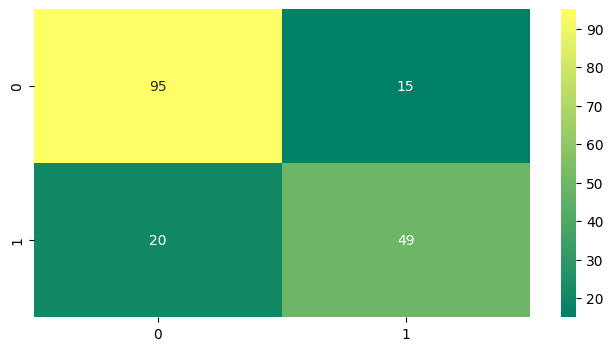

In [43]:
model_prediction(DecisionTreeClassifier())

# Random Forest

Accuracy_Score of RandomForestClassifier() model on Training Data is: 98.17415730337079
Accuracy_Score of RandomForestClassifier() model on Testing Data is: 82.68156424581005

------------------------------------------------------------------------
Precision Score of RandomForestClassifier() model is: 0.8275862068965517
Recall Score of RandomForestClassifier() model is: 0.6956521739130435
F1 Score of RandomForestClassifier() model is: 0.7559055118110236

------------------------------------------------------------------------
Confusion Matrix of RandomForestClassifier() model is:


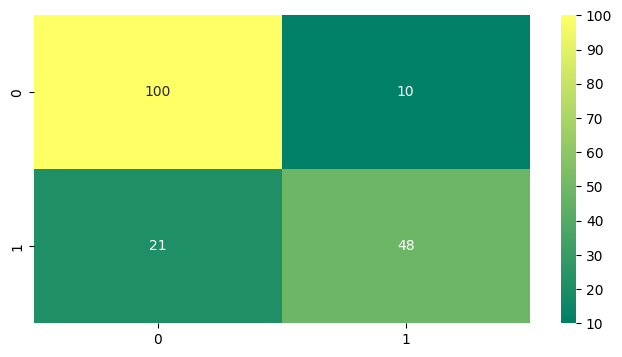

In [44]:
model_prediction(RandomForestClassifier())

# LGBM Classifier

In [ ]:
model_prediction(LGBMClassifier(force_col_wise=True, verbose=-1, max_depth=7, num_leaves=31, min_split_gain=0, min_child_samples=20))

# Ada Boost

Accuracy_Score of AdaBoostClassifier() model on Training Data is: 84.26966292134831
Accuracy_Score of AdaBoostClassifier() model on Testing Data is: 82.68156424581005

------------------------------------------------------------------------
Precision Score of AdaBoostClassifier() model is: 0.7878787878787878
Recall Score of AdaBoostClassifier() model is: 0.7536231884057971
F1 Score of AdaBoostClassifier() model is: 0.7703703703703704

------------------------------------------------------------------------
Confusion Matrix of AdaBoostClassifier() model is:


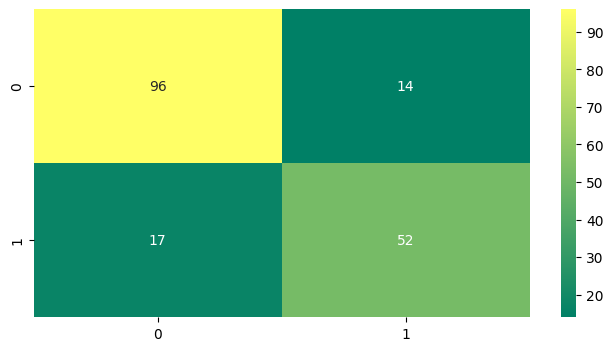

In [45]:
model_prediction(AdaBoostClassifier())

# Gradient Boosting Classifier

Accuracy_Score of GradientBoostingClassifier() model on Training Data is: 90.58988764044943
Accuracy_Score of GradientBoostingClassifier() model on Testing Data is: 84.35754189944134

------------------------------------------------------------------------
Precision Score of GradientBoostingClassifier() model is: 0.8727272727272727
Recall Score of GradientBoostingClassifier() model is: 0.6956521739130435
F1 Score of GradientBoostingClassifier() model is: 0.7741935483870968

------------------------------------------------------------------------
Confusion Matrix of GradientBoostingClassifier() model is:


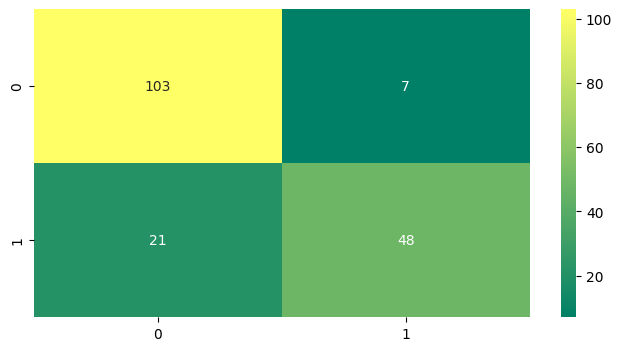

In [46]:
model_prediction(GradientBoostingClassifier())

# XGBoost

Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) model on Training Data is: 96.48876404494382
Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, de

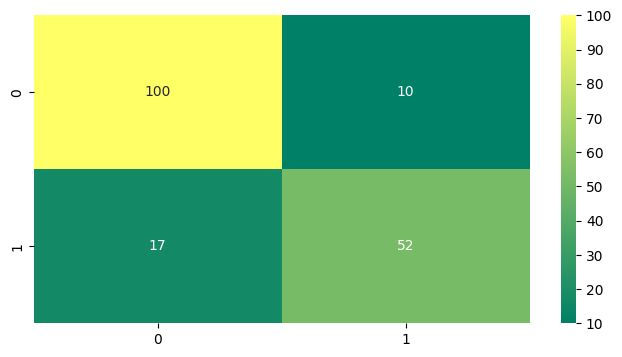

In [47]:
model_prediction(XGBClassifier())

# Cat Boost

Accuracy_Score of <catboost.core.CatBoostClassifier object at 0x7a94b8733510> model on Training Data is: 90.58988764044943
Accuracy_Score of <catboost.core.CatBoostClassifier object at 0x7a94b8733510> model on Testing Data is: 84.35754189944134

------------------------------------------------------------------------
Precision Score of <catboost.core.CatBoostClassifier object at 0x7a94b8733510> model is: 0.8596491228070176
Recall Score of <catboost.core.CatBoostClassifier object at 0x7a94b8733510> model is: 0.7101449275362319
F1 Score of <catboost.core.CatBoostClassifier object at 0x7a94b8733510> model is: 0.7777777777777778

------------------------------------------------------------------------
Confusion Matrix of <catboost.core.CatBoostClassifier object at 0x7a94b8733510> model is:


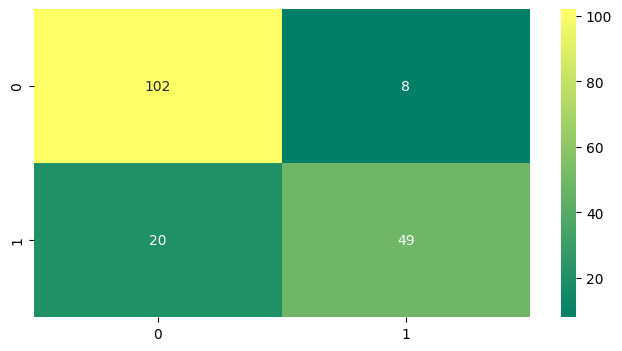

In [48]:
model_prediction(CatBoostClassifier(verbose=False))

In [49]:
models = ["Logistic Regression","KNN","SVM","Naive Bayes","Decision Tree","Random Forest","Ada Boost",
          "Gradient Boost","XGBoost", "CatBoost"]

In [50]:
df = pd.DataFrame({"Algorithms":models,
                   "Training Score":training_score,
                   "Testing Score":testing_score})
df

,Algorithms,Training Score,Testing Score
0,Logistic Regression,79.915730,79.888268
1,KNN,85.674157,83.240223
2,SVM,83.988764,81.564246
3,Naive Bayes,78.651685,79.329609
4,Decision Tree,98.174157,80.446927
5,Random Forest,98.174157,82.681564
6,Ada Boost,84.269663,82.681564
7,Gradient Boost,90.589888,84.357542
8,XGBoost,96.488764,84.916201
9,CatBoost,90.589888,84.357542


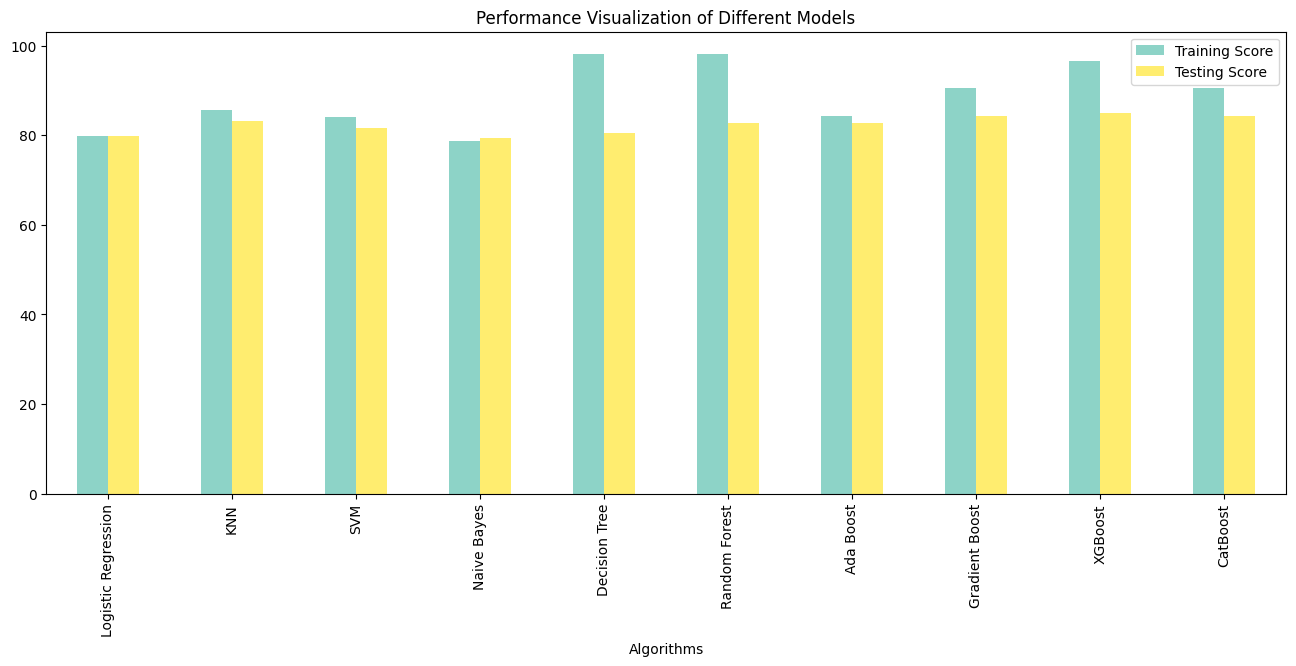

In [51]:
df.plot(x="Algorithms",y=["Training Score","Testing Score"], figsize=(16,6),kind="bar",
        title="Performance Visualization of Different Models",colormap="Set3")
plt.show()

# Hyper Parameter Tuning Of Best Models

In [52]:
model1 = GradientBoostingClassifier()

In [56]:
parameters1 = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3]
}

In [57]:
search = RandomizedSearchCV(
    model1,
    parameters1,
    cv=5,
    n_iter=7,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

In [58]:
search.fit(x_train, y_train.values.ravel())

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=7,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 3],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   random_state=42, scoring='accuracy')

In [59]:
search.best_score_

0.8257559342066385

In [60]:
best_parameters1 = search.best_params_
best_parameters1

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 3,
 'learning_rate': 0.1}

In [61]:
model1 = GradientBoostingClassifier(**best_parameters1)

In [62]:
model1.fit(x_train,y_train)

GradientBoostingClassifier(min_samples_split=5)

In [63]:
x_test_pred1 = model1.predict(x_test)

In [64]:
accuracy_score(y_test,x_test_pred1)

0.8491620111731844

In [65]:
model2 = CatBoostClassifier(verbose=False)

In [66]:
parameters2 = {"learning_rate":[0.1,0.3,0.5,0.6,0.7],
              "random_state":[0,42,48,50],
               "depth":[8,9,10],
               "iterations":[35,40,50]}

In [67]:
grid_search2 = GridSearchCV(model2, parameters2, cv=5, n_jobs=-1)

In [68]:
grid_search2.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7a94b7732a50>,
             n_jobs=-1,
             param_grid={'depth': [8, 9, 10], 'iterations': [35, 40, 50],
                         'learning_rate': [0.1, 0.3, 0.5, 0.6, 0.7],
                         'random_state': [0, 42, 48, 50]})

In [69]:
grid_search2.best_score_

0.8356643356643356

In [70]:
best_parameters2 = grid_search2.best_params_
best_parameters2

{'depth': 8, 'iterations': 40, 'learning_rate': 0.7, 'random_state': 42}

In [71]:
model2 = CatBoostClassifier(**best_parameters2,verbose=False)

In [72]:
model2.fit(x_train,y_train)

In [73]:
x_test_pred2 = model2.predict(x_test)

In [74]:
accuracy_score(y_test,x_test_pred2)

0.8324022346368715

In [75]:
model3 = XGBClassifier(random_state=42)

In [76]:
parameters3 = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0]
}

In [77]:
grid_search3 = GridSearchCV(model3, parameters3 , cv=5, n_jobs=-1)

In [78]:
grid_search3.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9, 1.0],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'subsample': [0.7, 0.9, 1.0]})

In [79]:
grid_search3.best_score_

0.8384418398502905

In [80]:
best_parameters3 = grid_search3.best_params_
best_parameters3

{'colsample_bytree': 1.0,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 1.0}

In [81]:
model3 = XGBClassifier(**best_parameters3)

In [82]:
model3.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [83]:
x_test_pred3 = model3.predict(x_test)

In [84]:
accuracy_score(y_test,x_test_pred3)

0.8435754189944135

In [85]:
model4 = RandomForestClassifier()

In [86]:
parameters4 = {'n_estimators': [100,300,500,550],
               'min_samples_split':[7,8,9],
               'max_depth': [10,11,12], 
               'min_samples_leaf':[4,5,6]}

In [87]:
grid_search4 = GridSearchCV(model4, parameters4, cv=5, n_jobs=-1)

In [88]:
grid_search4.fit(x_train,y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12],
                         'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [7, 8, 9],
                         'n_estimators': [100, 300, 500, 550]})

In [89]:
grid_search4.best_score_

0.8314389835516597

In [90]:
best_parameters4 = grid_search4.best_params_
best_parameters4

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 9,
 'n_estimators': 100}

In [91]:
model4 = RandomForestClassifier(**best_parameters4)

In [92]:
model4.fit(x_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=9)

In [93]:
x_test_pred4 = model4.predict(x_test)

In [95]:
accuracy_score(y_test,x_test_pred4)

0.8324022346368715

In [96]:
model5 = KNeighborsClassifier()

parameters5 = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

grid_search5 = GridSearchCV(model5, parameters5, cv=5, n_jobs=-1)

grid_search5.fit(x_train,y_train.values.ravel())

grid_search5.best_score_

best_parameters5 = grid_search5.best_params_
best_parameters5

model5 = KNeighborsClassifier(**best_parameters5)

model5.fit(x_train,y_train)

x_test_pred5 = model5.predict(x_test)

accuracy_score(y_test,x_test_pred5)

0.7653631284916201

In [97]:
stacking_model = StackingClassifier(estimators=[('CAT Boost', model2),
                                                ("XGBoost", model3),
                                                ('RF', model4),
                                                ('Gradient Boost',model1 ),
                                                ('KNN', model5)])

stacking_model.fit(x_train, y_train)

x_train_pred5 = stacking_model.predict(x_train)

x_test_pred5 = stacking_model.predict(x_test)

print("Stacking Model accuracy on Training Data is:",accuracy_score(y_train,x_train_pred5)*100)

print("Stacking Model accuracy on Testing Data is:",accuracy_score(y_test,x_test_pred5)*100)



Stacking Model accuracy on Training Data is: 91.85393258426966
Stacking Model accuracy on Testing Data is: 84.91620111731844


In [98]:
train.rename(columns={'Age Group': 'Age_Group'}, inplace=True)
test.rename(columns={'Age Group': 'Age_Group'}, inplace=True)

In [99]:
pred = stacking_model.predict(test)

original_test = pd.read_csv('/kaggle/input/titanic/test.csv')
submission = original_test[['PassengerId']]

submission["Survived"] = pred

submission.to_csv("submission.csv",index=False)

In [100]:
model3.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [101]:
x_train_pred5 = model3.predict(x_train)

In [102]:
x_test_pred5 = model3.predict(x_test)

In [103]:
print("Stacking Model accuracy on Training Data is:",accuracy_score(y_train,x_train_pred5)*100)

Final Model(XGBoost) accuracy on Training Data is: 88.48314606741573


In [104]:
print("Stacking Model accuracy on Testing Data is:",accuracy_score(y_test,x_test_pred5)*100)

Stacking Model accuracy on Testing Data is: 84.35754189944134


In [105]:
test.columns = test.columns.str.replace('Solo_0$', 'Solo_0.0', regex=True)
test.columns = test.columns.str.replace('Solo_1$', 'Solo_1.0', regex=True)

In [106]:
pred = model3.predict(test)

In [107]:
pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [108]:
original_test = pd.read_csv('/kaggle/input/titanic/test.csv')
submission = original_test[['PassengerId']]

In [109]:
submission["Survived"] = pred

In [110]:
# submission["Survived"].replace({1:True,0:False},inplace=True)

In [111]:
submission.to_csv("submission.csv",index=False)